In [1]:
import torch
import cvxpy as cp
from scipy.optimize import linear_sum_assignment

In [2]:
from optimal_transport import *
from utils import *

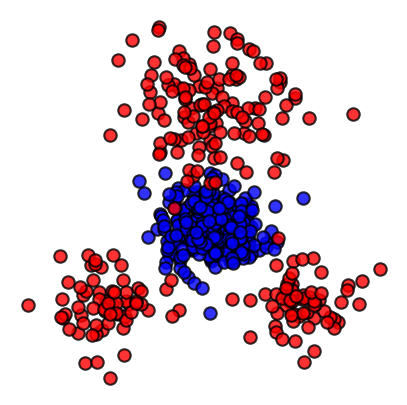

In [3]:
n = 256  # Number of points in first point cloud
m = n  # Number of points in second point cloud

# Generate point clouds a and b
gauss = lambda q, a, c: a * np.random.randn(2, q) + np.transpose(np.tile(c, (q, 1)))
a = (np.random.randn(2, n)*.3).transpose()
b = (np.hstack((gauss(int(m/2), .5, [0, 1.6]),
     np.hstack((gauss(int(m/4), .3, [-1, -1]), 
                gauss(int(m/4), .3, [1, -1])))))).transpose()

cloud_plot(a, b)

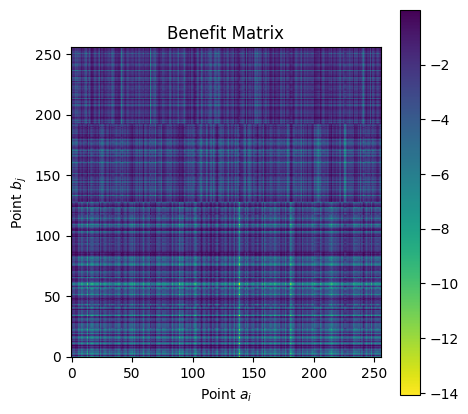

In [4]:
c_matrix = cost_matrix(a, b)

plt.figure(figsize=(5, 5))
plt.imshow(-c_matrix.transpose(), cmap='viridis_r')
plt.gca().invert_yaxis()
plt.title('Benefit Matrix')
plt.xlabel('Point $a_{i}$')
plt.ylabel('Point $b_{j}$')
plt.colorbar()
plt.show()

In [5]:
assignments = auction_algorithm(a[None], b[None], 2, 1e2, 1e-3, 10)

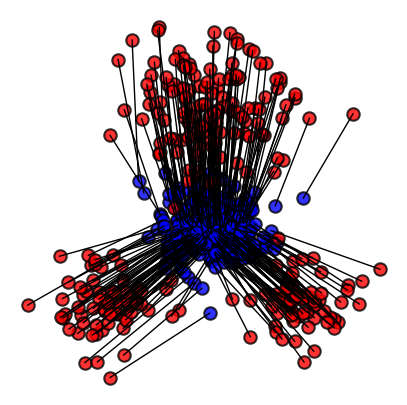

In [6]:
cloud_plot(a, b, assignments.squeeze())

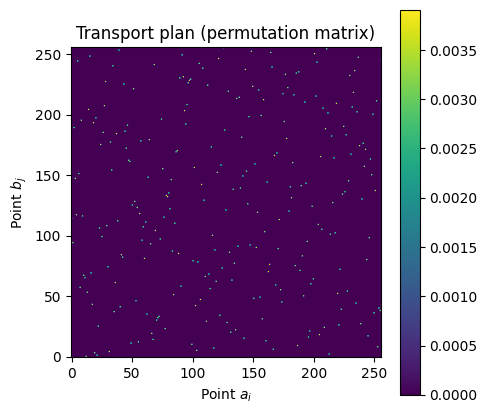

In [7]:
x = np.ones([n, 1])/n
y = x

p = cp.Variable((n, m))  # Define the optimization variable P

# Define the set of discrete couplings between alpha and beta measures
u = np.ones((m, 1))
v = np.ones((n, 1))

# Define optimization constraints
constraints = [0 <= p, cp.matmul(p, u)==x, cp.matmul(p.T, v)==y]

# Define and solve the Kantorovich problem
objective = cp.Minimize(cp.sum(cp.multiply(p, c_matrix)))
prob = cp.Problem(objective, constraints)
result = prob.solve(solver=cp.ECOS)

plt.figure(figsize=(5, 5))
plt.imshow(p.value, cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Transport plan (permutation matrix)')
plt.xlabel('Point $a_{i}$')
plt.ylabel('Point $b_{j}$')
plt.colorbar()
plt.show()

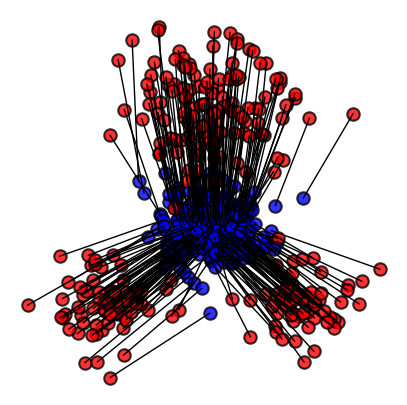

In [8]:
cloud_plot(a, b, t_plan=p)

In [9]:
%%timeit

result = prob.solve(solver=cp.ECOS)

861 ms ± 54.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%%timeit

assignments = auction_algorithm(a[None], b[None], 2, 1e2, 1e-3, 10)

22.9 ms ± 423 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
%%timeit

c_matrix = cost_matrix(a, b)
i_ind, j_ind = linear_sum_assignment(c_matrix.T)

26.4 ms ± 456 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
